# ISAZI Case Study 1 - Sales volume forecasting for online retailer

In [46]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt

matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'

# Import data
df = pd.read_csv("DS - case study 1 - add material - sales_volumes.csv")

Decided to use the Seasonal ARIMA model for this task, which will only use sales volume as the feature. This is done out of curiosity of learning traditional time series analysis techniques. Although SVR or ANNs can potentially take into account the impact of categorical features, such as product type and description, with respect to sales volume... 

# Sorting out the data

**Sneak peak into the data**

In [47]:
df.head()

,Unnamed: 0,InvoiceID,ProductCode,Description,Volume,Date,UnitPrice
0,42481,539993,22386,JUMBO BAG PINK POLKADOT,29,04-01-19 10:00,31.20
1,42482,539993,21499,BLUE POLKADOT WRAP,74,04-01-19 10:00,6.72
2,42483,539993,21498,RED RETROSPOT WRAP,74,04-01-19 10:00,6.72
3,42484,539993,22379,RECYCLING BAG RETROSPOT,14,04-01-19 10:00,33.60
4,42485,539993,20718,RED RETROSPOT SHOPPER BAG,29,04-01-19 10:00,20.00


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203422 entries, 0 to 203421
Data columns (total 7 columns):
Unnamed: 0     203422 non-null int64
InvoiceID      203422 non-null object
ProductCode    203422 non-null object
Description    202623 non-null object
Volume         203422 non-null int64
Date           203422 non-null object
UnitPrice      203422 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 10.9+ MB


In [49]:
df.isna().sum()

Unnamed: 0       0
InvoiceID        0
ProductCode      0
Description    799
Volume           0
Date             0
UnitPrice        0
dtype: int64

In [50]:
df.describe()

,Unnamed: 0,Volume,UnitPrice
count,203422.000000,203422.000000,203422.000000
mean,144191.500000,27.757052,78.045115
std,58723.017567,722.763945,1818.986812
min,42481.000000,-222646.000000,0.000000
25%,93336.250000,2.000000,20.000000
50%,144191.500000,8.000000,33.600000
75%,195046.750000,29.000000,66.080000
max,245902.000000,222644.000000,623520.000000


In [51]:
df[['InvoiceID', 'ProductCode', 'Description']].describe()

,InvoiceID,ProductCode,Description
count,203422,203422,202623
unique,10770,3531,3484
top,558475,22423,WHITE HANGING HEART T-LIGHT HOLDER
freq,705,1080,1099


Some observations:
 - Date needs to be converted into datetime for datetime indexing. Need to resample the data into daily time series.
 - There is a bunch of missing values in the description column
 - Minimum value in sales volume is almost the same as maximum value in sales volume. Probably the same items sold were returned?
 - Suprised to see maximum value of unit price is higher than that of volume.

**Preprocessing data**

In [52]:
# Convert Date column to datetime type and set as index
df.Date = pd.to_datetime(df.Date, format="%d-%m-%y %H:%M")
df = df.set_index('Date')
df.head()

,Unnamed: 0,InvoiceID,ProductCode,Description,Volume,UnitPrice
Date,,,,,,
2019-01-04 10:00:00,42481,539993,22386,JUMBO BAG PINK POLKADOT,29,31.20
2019-01-04 10:00:00,42482,539993,21499,BLUE POLKADOT WRAP,74,6.72
2019-01-04 10:00:00,42483,539993,21498,RED RETROSPOT WRAP,74,6.72
2019-01-04 10:00:00,42484,539993,22379,RECYCLING BAG RETROSPOT,14,33.60
2019-01-04 10:00:00,42485,539993,20718,RED RETROSPOT SHOPPER BAG,29,20.00


In [53]:
# Removing all features except for Volume
cols = ['Unnamed: 0', 'InvoiceID', 'ProductCode', 'Description', 'UnitPrice']
df_clean = df.drop(cols, axis=1)
df_clean.head()

,Volume
Date,
2019-01-04 10:00:00,29
2019-01-04 10:00:00,74
2019-01-04 10:00:00,74
2019-01-04 10:00:00,14
2019-01-04 10:00:00,29


**Resampling dataset to daily sales volume**

Missing days means zero volume sold. There should be 178 days in total in the dataset, given that January data started on the 4th.

In [54]:
df_clean = df_clean.resample(rule='D').sum()
df_clean.shape

(178, 1)

# Investigating the data

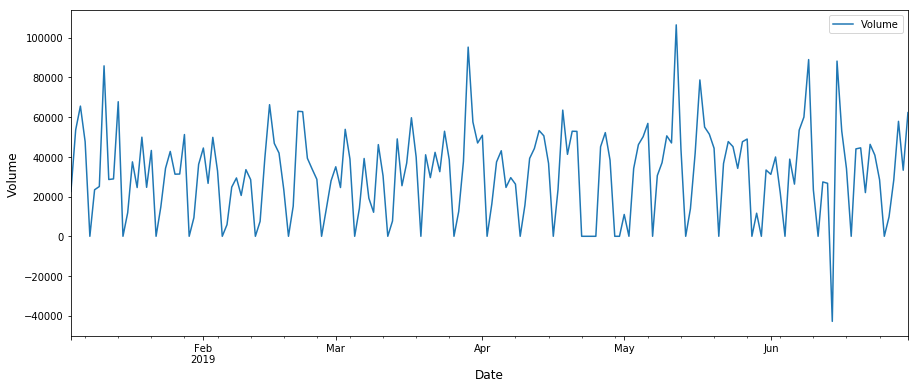

In [55]:
df_clean.plot(figsize=(15,6))
plt.ylabel('Volume')
plt.show()

The time series have seasonality pattern. Seems like sales always dip on a weekly basis. Also we can see there are a ton of returns in the middle of June, which is clearly an outlier given the data sample range. Sales volume flatlined for a few days in April, probably due to public holidays. It's suprising to see an online retail store to have this kind of sales characteristics...

**Investigating the large amount of returns in June**

In [56]:
# Extract June data from dataset and check when the significant return of product took place
df_june = df[df.index >= dt.datetime(2019,6,1)]
df_june.sort_values('Volume').head(10) # Check largest 10 returned items in June

,Unnamed: 0,InvoiceID,ProductCode,Description,Volume,UnitPrice
Date,,,,,,
2019-06-14 10:37:00,225529,556690,23005,printing smudges/thrown away,-28801,0.0
2019-06-14 10:37:00,225530,556691,23005,printing smudges/thrown away,-28801,0.0
2019-06-14 10:36:00,225528,556687,23003,Printing smudges/thrown away,-27175,0.0
2019-06-28 16:34:00,242906,558379,22618,"mouldy, unsaleable.",-5044,0.0
2019-06-13 11:21:00,224419,C556522,22920,HERB MARKER BASIL,-4546,8.8
2019-06-21 11:33:00,234739,557596,23114,Damaged,-4321,0.0
2019-06-21 11:35:00,234765,557600,23117,Damaged,-4321,0.0
2019-06-16 15:58:00,229728,557108,23113,Damaged,-4321,0.0
2019-06-21 11:34:00,234764,557599,23116,Damaged,-4321,0.0


It seems like some product had printing smudges and got thrown away on the 14th of June. This does not seem like a frequent occurence and could skew the forecasting as this is the only day out of all 6 months that Volume went negative in total. Let's replace these product defected on the 14th with average returns on the same day.

In [57]:
# Calculating the average of returns (negative volume) on the 14th of June 
june_14_return_avg = df[(df.index>dt.datetime(2019,6,14)) & 
                        (df.index<dt.datetime(2019,6,15)) & 
                        (df.Volume<0)].Volume.mean()

# Replacing the 3 entries of returns seen on the 14th of June with the average returns calculated
idx = df[(df.index>dt.datetime(2019,6,14)) & (df.index<dt.datetime(2019,6,15)) & (df.Volume<-20000)].index
df.Volume.loc[list(idx)] = june_14_return_avg

**Apply the same procedure as before to clean the data for ARIMA model** (This won't be repeated in the actual script)

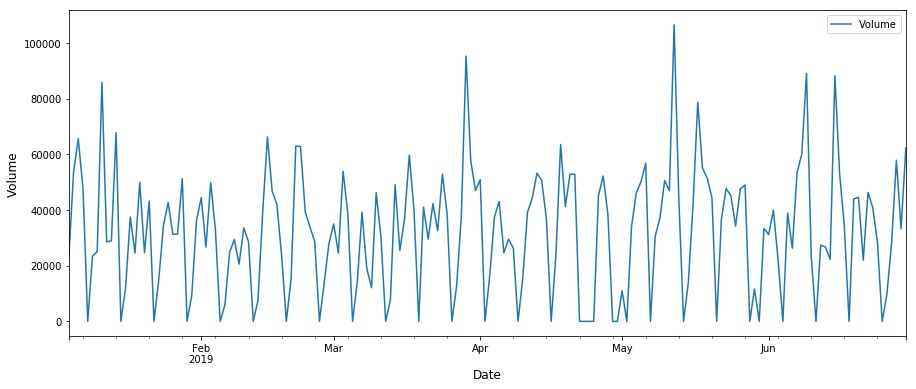

In [58]:
cols = ['Unnamed: 0', 'InvoiceID', 'ProductCode', 'Description', 'UnitPrice']
df_clean_2 = df.drop(cols, axis=1)
df_clean_2 = df_clean_2.resample(rule='D').sum()

# Splitting the data into train and test set
df_train = df_clean_2.iloc[:int(0.75*len(df_clean_2))]
df_test = df_clean_2.iloc[int(0.75*len(df_clean_2)):]

# Plotting the new sales volume data with largest returns on the 14th of June replaced by the average of returns
df_clean_2.plot(figsize=(15,6))
plt.ylabel('Volume')
plt.show()

# Get insight from data for SARIMA model

**Quick check on weekly moving average**

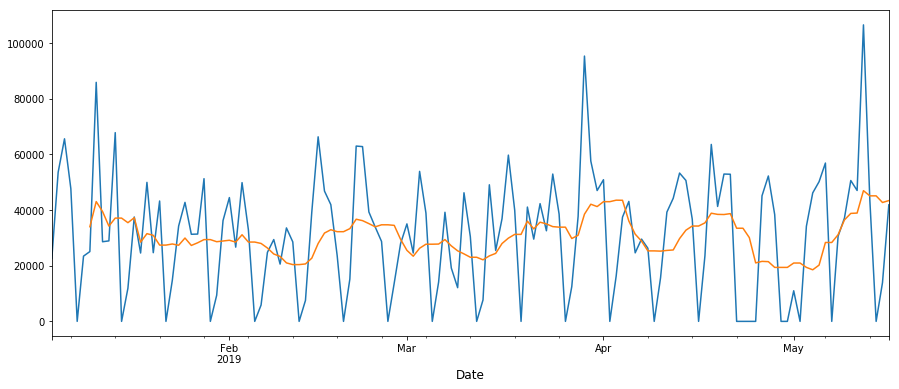

In [59]:
volume_ts = df_train.Volume
volume_ts.plot(figsize=(15,6))
volume_ts.rolling(7).mean().plot(label='Weekly rolling mean')
plt.show()

The weekly moving average seems to vary with time. This suggests non-stationarity.

**ETS Decomposition**<br>

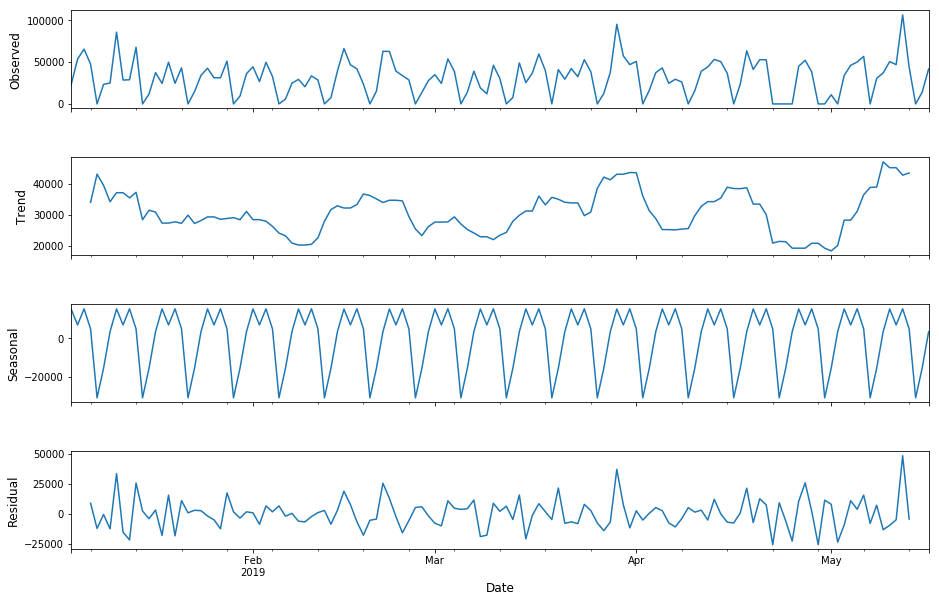

In [60]:
ets_decomp = seasonal_decompose(df_train.Volume.dropna(), model='additive')
fig = ets_decomp.plot()
fig.set_size_inches(15,10)

Very clear weekly seasonality can be seen. The trend characteristic seems to fluctuate between 20000 to 40000 daily sales volume. The residual error seems to have some equidistant positive spikes that's not explained by the trend nor seasonality (maybe discounted sales happen in a monthly cycle?). In any case, the above results further suggests that the data is non-stationary.

**Stationarity testing - Augmented Dickey-Fuller Test**<br>
Starting off with the ADF test. Null hypothesis is that the time series is non-stationary, and the alternative is that the time series is stationary. Deciding on the Null hypothesis based on p-value return.

In [61]:
result = adfuller(df_train.Volume.dropna())
print("ADF Test Summary")
labels = ['ADF Test Statistic', 'p-value', 'No. lags', 'Num of observations used', 'Critical Values']
    
for value, label in zip(result,labels):
    print(label+" : "+str(value))

ADF Test Summary
ADF Test Statistic : -4.260385784427605
p-value : 0.0005198607951992687
No. lags : 10
Num of observations used : 122
Critical Values : {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}


At this point the ADF test shows that the data is stationary without unit root. The p-value is less than 0.05 with no differencing performed on the data, and the null hypothesis is rejected. This is abit confusing as the plots from earlier shows seasonality and seems to have a fluctuating trend. Let's look at the ACF and PACF plots to get more clarity.

**ACF and PACF plots**

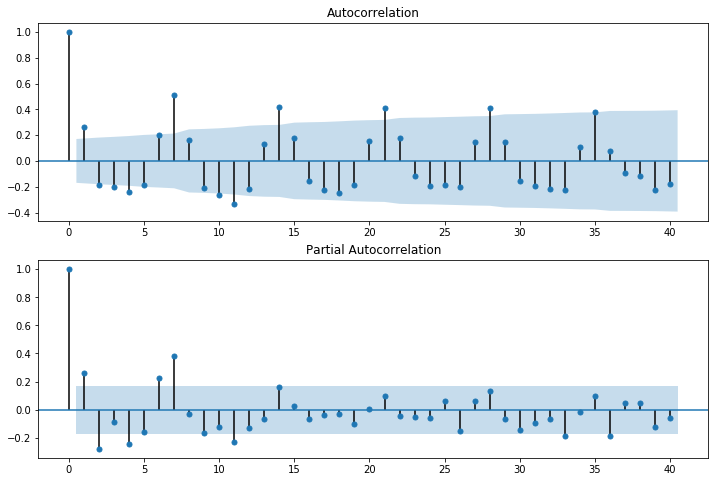

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_train.Volume, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_train.Volume, lags=40, ax=ax2)

The ACF seem to have AC out to a high order of lag. This means higher order of differencing should be applied. The ADF test  is tailored for detecting nonstationarity in the form of a unit root in the process, which is not exactly geared towards detecting nonstationarity of the seasonal kind (Did some research here). Let's check the impact of applying several differencing on ACF and PACF. Since the time series is seasonal, seasonal differencing should be considered too.

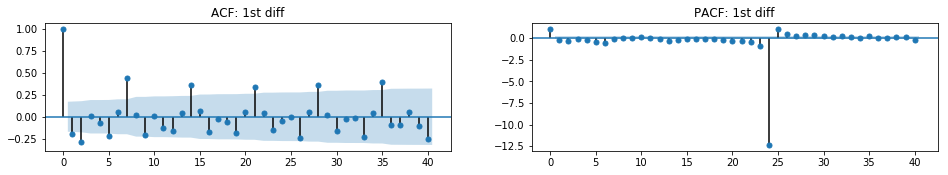

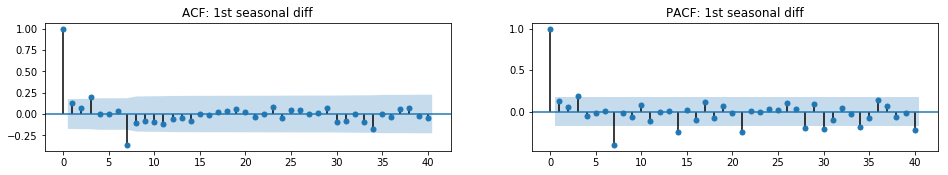

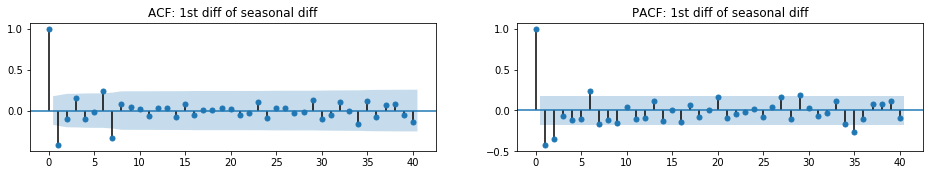

In [63]:
# Apply differencing: 1 order of difference, 1 order of seasonal difference, first difference of seasonal difference
df_train['diff_1'] = df_train['Volume'] - df_train['Volume'].shift(1)
df_train['diff_season'] = df_train['Volume'] - df_train['Volume'].shift(7)
df_train['diff_season_1'] = df_train['diff_season'] - df_train['diff_season'].shift(1)

# First difference
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(321)
fig = plot_acf(df_train.diff_1.dropna(), lags=40, ax=ax1, title='ACF: 1st diff')
ax2 = fig.add_subplot(322)
fig = plot_pacf(df_train.diff_1.dropna(), lags=40, ax=ax2, title='PACF: 1st diff')

# First seasonal difference
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(323)
fig = plot_acf(df_train.diff_season.dropna(), lags=40, ax=ax1, title='ACF: 1st seasonal diff')
ax2 = fig.add_subplot(324)
fig = plot_pacf(df_train.diff_season.dropna(), lags=40, ax=ax2, title='PACF: 1st seasonal diff')

# First difference of seasonal difference
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(325)
fig = plot_acf(df_train.diff_season_1.dropna(), lags=40, ax=ax1, title='ACF: 1st diff of seasonal diff')
ax2 = fig.add_subplot(326)
fig = plot_pacf(df_train.diff_season_1.dropna(), lags=40, ax=ax2, title='PACF: 1st diff of seasonal diff')

Applying first differencing didn't seem to do the trick, and applying 1st difference of seasonal difference seems to result in over differencing (negative ACs). Therefore, increasing the seasonal difference by an order seems like to be the best option to start off with for the SARIMA model.

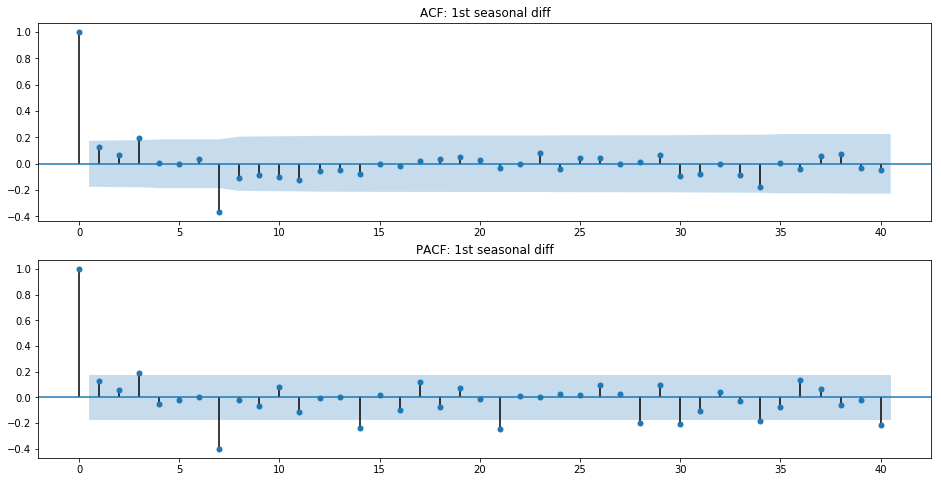

In [64]:
# First seasonal difference
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_train.diff_season.dropna(), lags=40, ax=ax1, title='ACF: 1st seasonal diff')
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_train.diff_season.dropna(), lags=40, ax=ax2, title='PACF: 1st seasonal diff')

**Model Fitting - Choosing p, q, sP and sQ parameters for SARIMA**

A grid search will be used to find the optimal p, q, sP and sQ parameters for the SARIMA model based on AIC scoring. The differencing terms will be set as d = 0 and sD = 1, based on previous analysis with the ACF and PACF plots.

In [65]:
# Create a grid for the ARIMA pdq and seasonal PDQ parameters
p = d = q = range(0,3) # Starting off with just first order AR and AM models
ps = ds = qs = range(0,3)
pdq = [(x[0], 0, x[2]) for x in list(itertools.product(p, d, q))] # Always set the d term to 0
seasonal_pdq = [(x[0], 1, x[2], 7) for x in list(itertools.product(ps, ds, qs))] # Always set the D term to 1

# Train and evaluate the SARIMA model using the parameter grid defined
best_score, best_order, best_sorder = float('inf'), (), ()
for param in list(set(pdq)): # Extract unique parameter sets from pdq
    for param_seasonal in list(set(seasonal_pdq)): # Extract unique parameter sets from seasonal_pdqand
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train.Volume,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            mod_fit = mod.fit()
            score_aic = mod_fit.aic
            
            if score_aic < best_score:
                best_score = score_aic
                best_order = param
                best_sorder = param_seasonal
        except:
            continue
            
# Fitting the model with best parameters             
mod = sm.tsa.statespace.SARIMAX(df_train.Volume,
                                order=best_order,
                                seasonal_order=best_sorder,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
mod_fit = mod.fit()

print(f'Best AIC: {best_score} \nBest pdq: {best_order} \nBest Seasonal pdq: {best_sorder}')

Best AIC: 2421.504857790975 
Best pdq: (1, 0, 2) 
Best Seasonal pdq: (0, 1, 2, 7)


**Checking diagnostics**

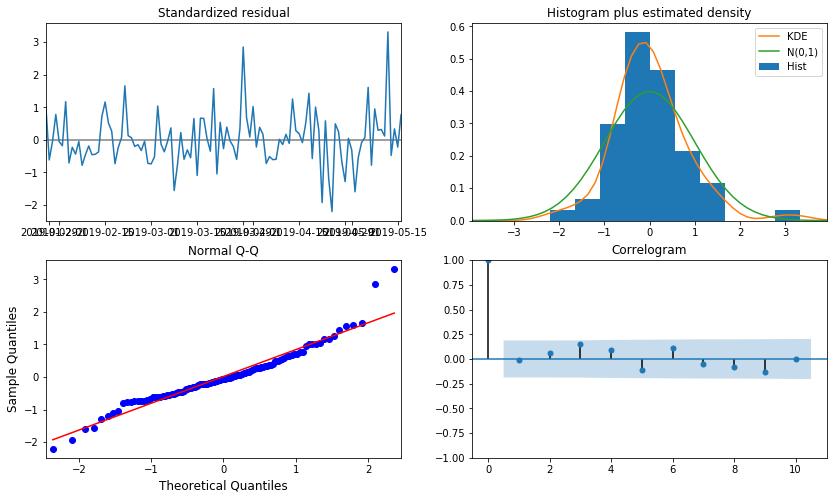

In [66]:
mod_fit.plot_diagnostics(figsize=(14,8))
plt.show()

From the diagnostic plots, it seems like that the residual errors fluctuate around a mean of 0 and have a relatively uniform variance. Although the quantile plot suggests that the distribution is slightly skewed to the right. The ACF shows that the residual errors are mostly not autocorrelated, which is good.

**Checking predictions on Test set**

In [67]:
df_test.shape

(45, 1)

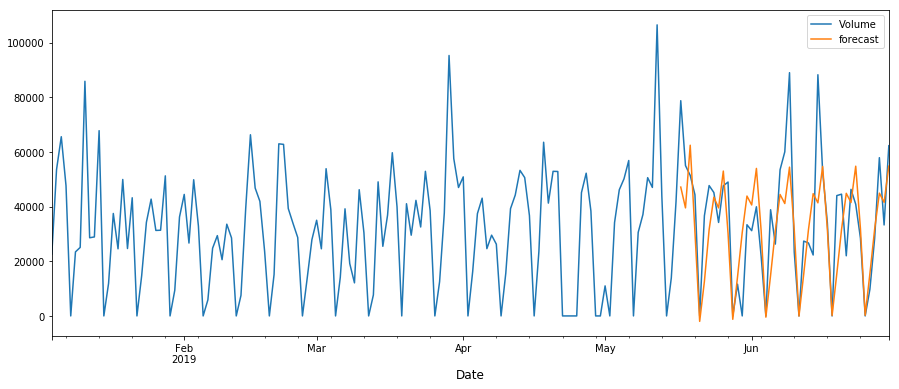

In [68]:
df_clean_2['forecast'] = mod_fit.predict(start = len(df_train), end= len(df_train)+45, dynamic= False)  #Test set has 45 entries
df_clean_2[['Volume', 'forecast']].plot(figsize=(15,6))

In [69]:
# Check overall accuracy for predictions made on test set
df_test['forecast'] = df_clean_2.forecast.iloc[len(df_train):]
accuracy = []
for x in df_test.forecast.loc[dt.datetime(2019,6,1):].index:
    
    if float(df_clean_2.loc[x, 'Volume']) == float(0):
        acc = 0 #(df_clean_2.loc[x, 'forecast'] - df_clean_2.loc[x, 'Volume'])
    else:
        acc = abs((df_clean_2.loc[x, 'forecast'] - df_clean_2.loc[x, 'Volume'])/df_clean_2.loc[x, 'Volume'])
    accuracy.append(acc)

print(f'The mean accuracy of the predicitons on test set is: {round(1-sum(accuracy)/len(accuracy),1)}')

The mean accuracy of the predicitons on test set is: 0.7


**Create Forecast for July**

In [70]:
from pandas.tseries.offsets import DateOffset

future_dates = [df_clean.index[-1] + DateOffset(days=x) for x in range(1,32)]
future_df = pd.DataFrame(index=future_dates, columns=df_clean.columns)
final_df = pd.concat([df_clean, future_df], sort=False)
final_df.head()

,Volume
2019-01-04,22633
2019-01-05,53562
2019-01-06,65551
2019-01-07,47631
2019-01-08,0


In [71]:
final_df.tail()

,Volume
2019-07-27,NaN
2019-07-28,NaN
2019-07-29,NaN
2019-07-30,NaN
2019-07-31,NaN


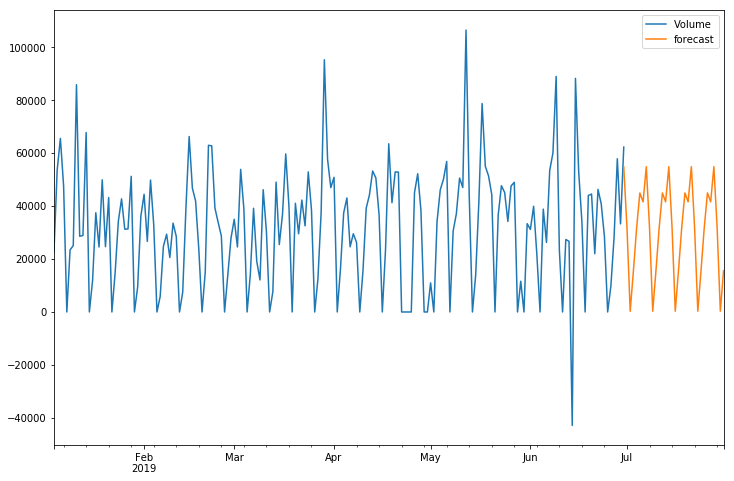

In [72]:
final_df['forecast'] = mod_fit.predict(start=len(df_clean)-1, end=len(df_clean)+31, dynamic=False)
final_df[['Volume', 'forecast']].plot(figsize=(12,8))

# Reporting

Bokeh library will be used for generating a HTML file for reporting the following:
 - Time series plot with past and future sales volumes
 - Data table with future sales volumes in July

In [73]:
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.layouts import gridplot

In [74]:
output_file('Forecast Results.html')

final_df = final_df.round(0) #Round forecast values to 0 decimal places

# Create a ColumnDataSource from past and forecasted sales volume
source_p = ColumnDataSource(pd.DataFrame(df.resample(rule='D').sum().Volume.loc[:dt.datetime(2019,7,1)])) # Past sales volume
source_f = ColumnDataSource(pd.DataFrame(final_df.forecast.loc[dt.datetime(2019,7,1):])) # Future sales volume
source_ft = ColumnDataSource(pd.DataFrame(final_df.forecast.loc[dt.datetime(2019,7,1):])) # Future sales volume, used for linking table to plot

# Setting up the time series plot
p = figure(x_axis_type = 'datetime',plot_height=650, plot_width=1000, title = 'Past and Future Sales Volume')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_alpha = 0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Volume'
p.xaxis[0].formatter.days = '%d-%m-%Y'
p.xaxis.major_label_orientation = 3.14/3 # Create a 60 degrees rotation of x-axis tick labels
p.line('Date', 'Volume', source=source_p, legend_label='Past Sales Volume')
p.line('index', 'forecast', source=source_f, line_color='red', legend_label='Future Sales Volume (July)')
p.circle('index', 'forecast', source=source_ft, line_color='green', fill_alpha=0.5, legend_label='Future Sales Volume (July)')

# Setting up the data table for July forecast
columns = [
    TableColumn(field='index', title='Future Date', formatter=DateFormatter()),
    TableColumn(field='forecast', title='Forcasted Sales [Units]'),
]
data_table = DataTable(source=source_ft, columns=columns, width=400, height=600)

# Combine both time series plot and data table in a grid plot, displayed columnwise, tool bar location will be on the right
plot = gridplot([[p,data_table]], toolbar_location="right")

show(plot)